In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import scipy.optimize as opt
from scipy.stats import norm
from scipy.optimize import curve_fit
from tqdm.auto import trange
from tqdm import tqdm
import Metropolis_Algorithm as MA

import importlib

importlib.reload(MA)

<module 'Metropolis_Algorithm' from 'C:\\Users\\sebas\\Documents\\GitHub\\Sebastian_Sloan_Computational_Physics\\Metropolis_Algorithm.py'>

In [2]:
# Setting Constants
x_0 = 0
y_0 = 0
t_i = 0
t_f = 8

mass = 1
steps = 150  # Reduced from 800 - fewer points to update
numb_paths = 1000

times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]

In [3]:
# Potential
def x_potential(x):
    return 1 / 2 * x ** 2


def y_potential(x):
    return 1000 * x ** 4


def ho_analytic_pdf(x):
    return (1 / np.sqrt(np.pi)) * np.exp(-x ** 2)


def residual_calculator1(x_values, model, model_parameters, y_values, y_errors):
    theoretical_values = model(x_values, *model_parameters)
    residuals = (y_values - theoretical_values) / y_errors
    return residuals

def residual_calculator2(theoretical_values, y_values, y_errors):
    residuals = (y_values - theoretical_values) / y_errors
    return residuals

# Propagator Data

In [42]:
# Setting Constants

#position boundaries
x_0_prop = 0
x_endpoints_prop = np.linspace(-2, 2, 201)

#time boundaries
t_i_prop = 0
t_f_prop = 6

#other constants
mass_prop = 1
steps_prop = 7
numb_paths_prop = 1000

#array of times
times_prop = np.linspace(t_i_prop, t_f_prop, steps_prop)
dt_prop = times_prop[1] - times_prop[0]
print(x_endpoints_prop)

[-2.   -1.98 -1.96 -1.94 -1.92 -1.9  -1.88 -1.86 -1.84 -1.82 -1.8  -1.78
 -1.76 -1.74 -1.72 -1.7  -1.68 -1.66 -1.64 -1.62 -1.6  -1.58 -1.56 -1.54
 -1.52 -1.5  -1.48 -1.46 -1.44 -1.42 -1.4  -1.38 -1.36 -1.34 -1.32 -1.3
 -1.28 -1.26 -1.24 -1.22 -1.2  -1.18 -1.16 -1.14 -1.12 -1.1  -1.08 -1.06
 -1.04 -1.02 -1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82
 -0.8  -0.78 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58
 -0.56 -0.54 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34
 -0.32 -0.3  -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1
 -0.08 -0.06 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14
  0.16  0.18  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38
  0.4   0.42  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62
  0.64  0.66  0.68  0.7   0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86
  0.88  0.9   0.92  0.94  0.96  0.98  1.    1.02  1.04  1.06  1.08  1.1
  1.12  1.14  1.16  1.18  1.2   1.22  1.24  1.26  1.28

In [43]:
#Creating the position generating function

def Pos_Gen_prop(x0, xN, Steps, noise_scale=0.3):  #Generates smooth paths with noise
    xs = np.linspace(x0, xN, Steps)
    noise = np.random.normal(0, noise_scale, size=Steps)
    noise[0] = 0.0
    noise[-1] = 0.0
    return xs + noise


#Creating function to evaluate the action integral for a path

def action_harmonic_prop(positions, times, mass):
    #Input Validation
    if type(positions) != np.ndarray:
        raise TypeError("WARNING: position input is not a numpy array")
    if type(times) != np.ndarray:
        raise TypeError("WARNING: time input is not a numpy array")

    #Calculating the action using discrete steps and straight line approx
    S = 0
    for i in range(len(times) - 1):
        dt = times[i + 1] - times[i]
        dx = positions[i + 1] - positions[i]
        T = 0.5 * mass * (dx / dt) ** 2
        V = 0.5 * (((positions[i] + positions[i + 1]) / 2) ** 2)
        S += dt * (T + V)

    return S

[ 0.          0.3009007  -0.95931226 -0.35896992 -1.35704456 -1.70980946
 -2.        ]
201000
201000
[[ 0.         -0.74112315 -1.00276628 -0.84233121 -1.45390067 -1.93010314
  -2.        ]
 [ 0.         -0.33656794 -0.94463236 -0.7682766  -1.37807651 -1.86043134
  -1.98      ]]
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000


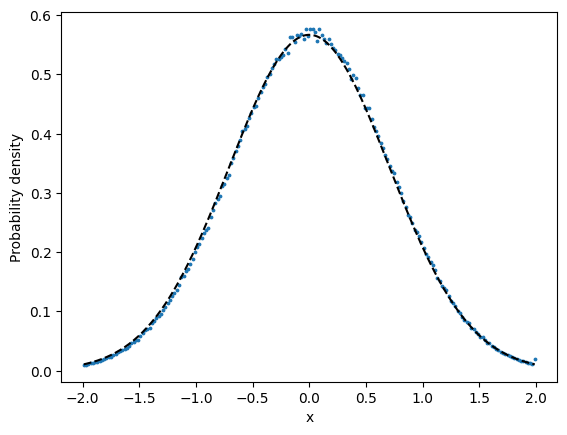

In [44]:
# Generating Paths and calculating weight of each path
paths_prop = []
weights_prop = []
x_end_prop = []

for xN in x_endpoints_prop:
    for _ in range(numb_paths_prop):
        p = Pos_Gen_prop(x_0_prop, xN, steps_prop)
        S = action_harmonic_prop(p, times_prop, mass_prop)
        w = np.exp(-S)
        paths_prop.append(p)
        weights_prop.append(w)
        x_end_prop.append(xN)

paths_prop = np.array(paths_prop)
weights_prop = np.array(weights_prop)
x_end_prop = np.array(x_end_prop)

print(paths_prop[0])
print(len(paths_prop))
print(len(paths_prop))
print(paths_prop[999:1001])

# Finding the groundstate wave function of the path
x_bins_prop = np.linspace(-2, 2, 201)

pdf_unnormalised_prop, bin_edges_prop = np.histogram(x_end_prop, bins=x_bins_prop, weights=weights_prop)
x_centres_prop = 0.5 * (bin_edges_prop[1:] + bin_edges_prop[:-1])
dx_prop = np.diff(x_bins_prop)[0]

# normalize to integrate to 0.5 (since we only use x > 0)
area_prop = np.sum(pdf_unnormalised_prop * dx_prop)
pdf_prop = pdf_unnormalised_prop / (area_prop)

# --- Analytic PDF for comparison (half side only) ---
phi_sq_analytic_prop = (1 / np.sqrt(np.pi)) * np.exp(-x_centres_prop ** 2)
phi_sq_analytic_prop /= np.sum(phi_sq_analytic_prop * dx_prop)  # normalize area to 0.5

# --- Check areas ---
print(f"Numerical PDF area: {np.sum(pdf_prop * dx_prop):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_prop * dx_prop):.5f}")

plt.figure(1)
plt.scatter(x_centres_prop, pdf_prop, label='Path integral estimate', s=3)
plt.plot(x_centres_prop, phi_sq_analytic_prop, 'k--', label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.show()

# Metropolis Data

Thermalizing...


Thermalising:  36%|███▌      | 178/500 [00:00<00:00, 1004.83it/s]

Endpoint acceptance ≈ 0.531
Endpoint acceptance ≈ 0.529


Thermalising:  80%|███████▉  | 398/500 [00:00<00:00, 1017.93it/s]

Endpoint acceptance ≈ 0.530
Endpoint acceptance ≈ 0.533


Thermalising: 100%|██████████| 500/500 [00:00<00:00, 961.64it/s] 


Endpoint acceptance ≈ 0.517

Sampling...


Sampling:   2%|▏         | 100/5000 [00:00<00:05, 865.96it/s]

Endpoint acceptance ≈ 0.546


Sampling:   4%|▍         | 192/5000 [00:00<00:04, 1012.87it/s]

Endpoint acceptance ≈ 0.510


Sampling:   6%|▌         | 290/5000 [00:00<00:05, 941.15it/s] 

Endpoint acceptance ≈ 0.548


Sampling:   8%|▊         | 400/5000 [00:00<00:04, 1077.46it/s]

Endpoint acceptance ≈ 0.525


Sampling:  10%|█         | 501/5000 [00:00<00:06, 694.78it/s] 

Endpoint acceptance ≈ 0.563
Endpoint acceptance ≈ 0.543


Sampling:  16%|█▌        | 800/5000 [00:00<00:03, 1057.35it/s]

Endpoint acceptance ≈ 0.526
Endpoint acceptance ≈ 0.524


Sampling:  20%|██        | 1004/5000 [00:01<00:04, 957.72it/s] 

Endpoint acceptance ≈ 0.554
Endpoint acceptance ≈ 0.520
Endpoint acceptance ≈ 0.513


Sampling:  26%|██▌       | 1305/5000 [00:01<00:03, 957.01it/s] 

Endpoint acceptance ≈ 0.513
Endpoint acceptance ≈ 0.518
Endpoint acceptance ≈ 0.516


Sampling:  32%|███▏      | 1599/5000 [00:01<00:02, 1189.46it/s]

Endpoint acceptance ≈ 0.546
Endpoint acceptance ≈ 0.535


Sampling:  36%|███▌      | 1797/5000 [00:01<00:03, 1026.84it/s]

Endpoint acceptance ≈ 0.532
Endpoint acceptance ≈ 0.508


Sampling:  40%|████      | 2005/5000 [00:02<00:03, 937.30it/s] 

Endpoint acceptance ≈ 0.534
Endpoint acceptance ≈ 0.521
Endpoint acceptance ≈ 0.505


Sampling:  46%|████▌     | 2308/5000 [00:02<00:02, 1191.75it/s]

Endpoint acceptance ≈ 0.530
Endpoint acceptance ≈ 0.527
Endpoint acceptance ≈ 0.541


Sampling:  52%|█████▏    | 2592/5000 [00:02<00:02, 923.50it/s] 

Endpoint acceptance ≈ 0.526
Endpoint acceptance ≈ 0.508


Sampling:  55%|█████▌    | 2750/5000 [00:02<00:02, 994.47it/s] 

Endpoint acceptance ≈ 0.543
Endpoint acceptance ≈ 0.524


Sampling:  60%|██████    | 3005/5000 [00:03<00:02, 923.90it/s] 

Endpoint acceptance ≈ 0.509
Endpoint acceptance ≈ 0.526
Endpoint acceptance ≈ 0.515


Sampling:  66%|██████▌   | 3302/5000 [00:03<00:01, 943.40it/s] 

Endpoint acceptance ≈ 0.547
Endpoint acceptance ≈ 0.489
Endpoint acceptance ≈ 0.553


Sampling:  72%|███████▏  | 3600/5000 [00:03<00:01, 1032.76it/s]

Endpoint acceptance ≈ 0.517
Endpoint acceptance ≈ 0.515


Sampling:  76%|███████▌  | 3794/5000 [00:03<00:01, 1028.43it/s]

Endpoint acceptance ≈ 0.548
Endpoint acceptance ≈ 0.519


Sampling:  80%|████████  | 4006/5000 [00:04<00:01, 915.85it/s] 

Endpoint acceptance ≈ 0.530
Endpoint acceptance ≈ 0.540
Endpoint acceptance ≈ 0.527


Sampling:  86%|████████▌ | 4305/5000 [00:04<00:00, 948.45it/s] 

Endpoint acceptance ≈ 0.505
Endpoint acceptance ≈ 0.546
Endpoint acceptance ≈ 0.516


Sampling:  92%|█████████▏| 4608/5000 [00:04<00:00, 963.12it/s] 

Endpoint acceptance ≈ 0.544
Endpoint acceptance ≈ 0.535
Endpoint acceptance ≈ 0.508


Sampling:  98%|█████████▊| 4896/5000 [00:04<00:00, 1064.82it/s]

Endpoint acceptance ≈ 0.536
Endpoint acceptance ≈ 0.536


Sampling: 100%|██████████| 5000/5000 [00:05<00:00, 991.10it/s] 


Endpoint acceptance ≈ 0.526

------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.7405 (expected ≈ 0.707)
Root mean square: 0.7405 (expected ≈ 0.707)


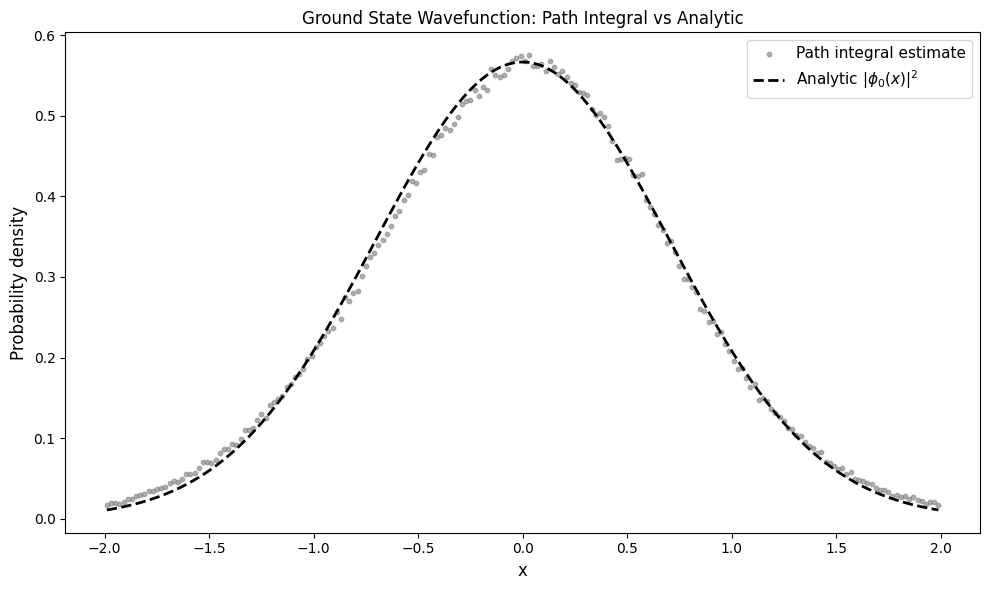

In [4]:
paths_x = np.array([
    MA.Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

paths_orig = paths_x.copy()
C = 1.8437008005694266
mid = paths_x.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_x = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_x.append(paths_x[:, -1].copy())

samples_x = np.concatenate(samples_x)

# Compute PDF
x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x, bin_edges_x = np.histogram(samples_x, bins=x_bins)

x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

pdf_x = pdf_unnormalised_x / np.sum(pdf_unnormalised_x * dx)

# Analytic PDF
phi_sq_analytic_x = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic_x /= np.sum(phi_sq_analytic_x * dx)

# Statistics
mean_square_x = np.mean(samples_x ** 2)
rms = np.sqrt(mean_square_x)
std = np.std(samples_x)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_x * dx):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=10, alpha=0.6, color='grey')
plt.plot(x_centres, phi_sq_analytic_x, 'black', linestyle='--', linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.tight_layout()
plt.show()

# Main Plot

In [46]:
#calculations for plot

#residuals for metropolis

metropolis_residiuals = (pdf_x - phi_sq_analytic_x)
metropolis_residuals_normalised = metropolis_residiuals/np.std(metropolis_residiuals)
print(np.std(metropolis_residuals_normalised))

propagator_residuals = (pdf_prop - phi_sq_analytic_x)
propagator_residuals_normalised = propagator_residuals/np.std(propagator_residuals)
print(np.std(propagator_residuals_normalised))

1.0
1.0


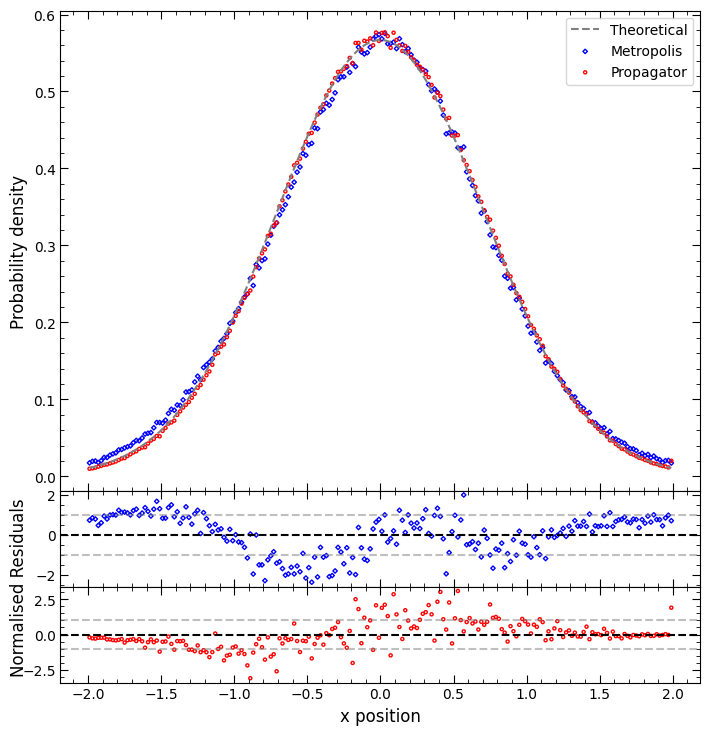

In [57]:
#plot
laptop_savepath_main_results = r"C:\Users\sebas\Documents\Durham Work\Year 3\Comp Phys\main_results.svg"

fig = plt.figure(1)

#main plot
fig.add_axes([0,0,1,1])
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

plt.plot(x_centres, phi_sq_analytic_x, linestyle = "--", color = "grey", label = "Theoretical")
plt.scatter(x_centres, pdf_x, marker = "D", s = 5,color = "blue", facecolor = "none", label = "Metropolis")
plt.scatter(x_centres, pdf_prop, marker = "o", s = 5, color = "red", facecolor = "none", label = "Propagator")

plt.legend()
plt.ylabel("Probability density", fontsize=12)


#residual plot 1
rp1 = fig.add_axes(([0,-0.2,1,0.2]))
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

rp1.axhline(0, color = 'black', linestyle = '--')
rp1.axhline(1, color = 'grey', linestyle = '--',alpha = 0.5)
rp1.axhline(-1, color = 'grey', linestyle = '--',alpha = 0.5)

plt.scatter(x_centres, metropolis_residuals_normalised, marker = "D", s = 5,color = "blue", facecolor = "none")


#residual plot 2
rp2 = fig.add_axes(([0,-0.4,1,0.2]))
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

rp2.axhline(0, color = 'black', linestyle = '--')
rp2.axhline(1, color = 'grey', linestyle = '--',alpha = 0.5)
rp2.axhline(-1, color = 'grey', linestyle = '--',alpha = 0.5)

plt.scatter(x_centres, propagator_residuals_normalised, marker = "o", s = 5, color = "red", facecolor = "none")

plt.xlabel("x position", fontsize=12)
rp2.set_ylabel("Normalised Residuals",fontsize=12)
rp2.yaxis.set_label_coords(-0.05,1)

plt.savefig(laptop_savepath_main_results, bbox_inches = 'tight')
plt.show()